In [1]:
import os
import re
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, log_loss,
    matthews_corrcoef, cohen_kappa_score
)

from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

print("OK - Librerías importadas")


OK - Librerías importadas


In [ ]:
DATA_PATH = "Dataset.csv"  
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró '{DATA_PATH}'. Verifica que esté en la misma carpeta del notebook.")

df = pd.read_csv(DATA_PATH)

print("Dataset cargado")
print("Shape:", df.shape)
display(df.head(10))


Dataset cargado
Shape: (7229, 31)


,empresa_id,rubro,anio,mes,mes_inicio,ingresos_15,gastos_fijos_15,gastos_variables_15,gastos_totales_15,ventas_15,activos_corrientes_15,pasivos_corrientes_15,margen_ganancia_15,liquidez_corriente_15,riesgo_15,prob_riesgo_15,ingresos_mes,gastos_fijos_mes,gastos_variables_mes,gastos_totales_mes,ventas_mes,activos_corrientes_mes,pasivos_corrientes_mes,utilidad_mes,margen_ganancia_mes,liquidez_corriente_mes,riesgo_fin_mes,prob_riesgo_fin_mes,mes_bueno,es_sintetico,riesgo_original_dataset
0,REAL_001,Desconocido,2024,1,2024-01-01,4110.70,2695.29,1154.75,3850.04,79,17612.37,10820.98,0.063410,1.627613,MEDIO,0.4811,6215.0,4118.0,1794.0,5912.0,118,18489.0,10507.0,303.0,0.048753,1.759684,MEDIO,0.4576,1,0,BAJO
1,REAL_002,Desconocido,2024,2,2024-02-01,2725.13,1734.31,340.88,2075.20,53,20584.32,9892.72,0.238495,2.080755,BAJO,0.2766,7674.0,3899.0,1009.0,4908.0,153,20979.0,9933.0,2766.0,0.360438,2.112051,BAJO,0.2192,1,0,BAJO
2,REAL_003,Desconocido,2024,3,2024-03-01,3594.38,1845.11,788.32,2633.43,70,16426.16,5900.70,0.267348,2.783765,BAJO,0.1891,6341.0,3808.0,1367.0,5175.0,121,16329.0,6053.0,1166.0,0.183883,2.697671,BAJO,0.2386,1,0,BAJO
3,REAL_004,Desconocido,2024,4,2024-04-01,5212.97,1250.11,1054.29,2304.40,94,27528.73,19387.80,0.557949,1.419900,BAJO,0.3328,10017.0,3686.0,1978.0,5664.0,202,29413.0,19181.0,4353.0,0.434561,1.533445,BAJO,0.3256,1,0,BAJO
4,REAL_005,Desconocido,2024,5,2024-05-01,4937.17,1508.40,1954.33,3462.73,96,19282.04,7819.27,0.298640,2.465963,BAJO,0.1991,8929.0,3893.0,3414.0,7307.0,183,19597.0,7799.0,1622.0,0.181655,2.512758,BAJO,0.2543,1,0,BAJO
5,REAL_006,Desconocido,2024,6,2024-06-01,3767.97,2304.06,1080.70,3384.76,75,11428.18,4867.70,0.101701,2.347758,BAJO,0.3206,5584.0,4021.0,1547.0,5568.0,110,11798.0,4780.0,16.0,0.002865,2.468201,BAJO,0.3743,1,0,BAJO
6,REAL_007,Desconocido,2024,6,2024-06-01,2138.69,1184.89,116.17,1301.06,1602,97.70,101.03,0.391658,0.967086,MEDIO,0.4864,4000.0,2000.0,200.0,2200.0,3000,100.0,100.0,1800.0,0.450000,1.000000,MEDIO,0.4637,1,0,BAJO
7,REAL_008,Desconocido,2024,7,2024-07-01,3893.05,2007.45,1005.65,3013.10,76,16399.21,6333.46,0.226031,2.589297,BAJO,0.2232,7960.0,4000.0,2184.0,6184.0,152,16436.0,6346.0,1776.0,0.223116,2.589978,BAJO,0.2247,1,0,BAJO
8,REAL_009,Desconocido,2024,8,2024-08-01,3141.18,1713.01,2033.06,3746.07,62,11562.01,4783.41,-0.192568,2.417107,MEDIO,0.4938,5769.0,3626.0,3428.0,7054.0,119,12501.0,4583.0,-1285.0,-0.222742,2.727689,MEDIO,0.4817,0,0,ALTO
9,REAL_010,Desconocido,2024,9,2024-09-01,4549.92,2100.02,630.61,2730.63,88,15962.23,5039.97,0.399850,3.167128,BAJO,0.1207,7505.0,3709.0,1156.0,4865.0,149,15587.0,5035.0,2640.0,0.351765,3.095730,BAJO,0.1392,1,0,BAJO


In [3]:
print("\n--- Tipos de dato ---")
display(df.dtypes)

print("\n--- Nulos por columna (Top 30) ---")
display(df.isna().sum().sort_values(ascending=False).head(30))

print("\n--- Duplicados ---")
print("Duplicados:", df.duplicated().sum())

print("\n--- Resumen estadístico numérico ---")
display(df.describe().T.head(30))



--- Tipos de dato ---


empresa_id                  object
rubro                       object
anio                         int64
mes                          int64
mes_inicio                  object
ingresos_15                float64
gastos_fijos_15            float64
gastos_variables_15        float64
gastos_totales_15          float64
ventas_15                    int64
activos_corrientes_15      float64
pasivos_corrientes_15      float64
margen_ganancia_15         float64
liquidez_corriente_15      float64
riesgo_15                   object
prob_riesgo_15             float64
ingresos_mes               float64
gastos_fijos_mes           float64
gastos_variables_mes       float64
gastos_totales_mes         float64
ventas_mes                   int64
activos_corrientes_mes     float64
pasivos_corrientes_mes     float64
utilidad_mes               float64
margen_ganancia_mes        float64
liquidez_corriente_mes     float64
riesgo_fin_mes              object
prob_riesgo_fin_mes        float64
mes_bueno           


--- Nulos por columna (Top 30) ---


riesgo_original_dataset    7200
ingresos_mes                  0
es_sintetico                  0
mes_bueno                     0
prob_riesgo_fin_mes           0
riesgo_fin_mes                0
liquidez_corriente_mes        0
margen_ganancia_mes           0
utilidad_mes                  0
pasivos_corrientes_mes        0
activos_corrientes_mes        0
ventas_mes                    0
gastos_totales_mes            0
gastos_variables_mes          0
gastos_fijos_mes              0
empresa_id                    0
rubro                         0
riesgo_15                     0
liquidez_corriente_15         0
margen_ganancia_15            0
pasivos_corrientes_15         0
activos_corrientes_15         0
ventas_15                     0
gastos_totales_15             0
gastos_variables_15           0
gastos_fijos_15               0
ingresos_15                   0
mes_inicio                    0
mes                           0
anio                          0
dtype: int64


--- Duplicados ---
Duplicados: 0

--- Resumen estadístico numérico ---


,count,mean,std,min,25%,50%,75%,max
anio,7229.0,2023.004012,1.412887,2021.000000,2022.000000,2023.000000,2024.000000,2025.000000
mes,7229.0,6.499793,3.451884,1.000000,4.000000,6.000000,10.000000,12.000000
ingresos_15,7229.0,3926.730823,1827.055567,602.260000,2612.270000,3590.740000,4880.630000,19053.650000
gastos_fijos_15,7229.0,2134.654443,1160.027897,273.260000,1306.520000,1907.050000,2680.030000,11777.870000
gastos_variables_15,7229.0,1137.725160,683.223720,59.760000,674.110000,997.960000,1450.760000,8486.820000
gastos_totales_15,7229.0,3272.379513,1702.130347,494.570000,2051.810000,2959.450000,4101.070000,16825.540000
ventas_15,7229.0,81.155208,53.937265,8.000000,47.000000,70.000000,103.000000,1634.000000
activos_corrientes_15,7229.0,20922.691530,10986.205747,97.700000,13085.030000,18584.550000,26227.160000,116743.360000
pasivos_corrientes_15,7229.0,15557.865908,12058.228968,101.030000,7385.610000,12188.190000,19961.250000,120202.880000
margen_ganancia_15,7229.0,0.159267,0.202570,-0.828064,0.038481,0.180869,0.300795,0.690865


In [5]:
def clean_text_series(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
         .str.strip()
         .str.upper()
         .replace({"NAN": np.nan, "NONE": np.nan})
    )

# Si existen estas columnas, las limpiamos:
for col in ["riesgo_15", "riesgo_fin_mes", "riesgo_original_dataset"]:
    if col in df.columns:
        df[col] = clean_text_series(df[col])

print("Limpieza básica de textos aplicada (si existían columnas).")


Limpieza básica de textos aplicada (si existían columnas).


In [25]:
TARGET = "riesgo_fin_mes"   
if TARGET not in df.columns:
    raise ValueError(f"No existe la columna objetivo '{TARGET}'. Columnas disponibles: {list(df.columns)[:30]} ...")

# 1) Candidatas seguras: columnas que terminan en _15
features_15 = [c for c in df.columns if c.endswith("_15")]

# 2) Variables de contexto (opcionales, si existen)
context_candidates = [
    "empresa_id", "empresa", "id_empresa",
    "rubro", "sector", "provincia", "region", "ciudad",
    "anio", "año", "mes", "mes_num", "periodo"
]
context_cols = [c for c in context_candidates if c in df.columns]

# 3) Lista inicial de features
X_cols = list(dict.fromkeys(features_15 + context_cols))  # sin duplicados manteniendo orden

# 4) Anti-leakage: eliminar cualquier cosa que sugiera "fin de mes"
LEAK_PATTERNS = [
    r"_mes$", r"_fin_mes$", r"fin_mes", r"cierre_mes", r"resultado_mes",
    r"utilidad_mes", r"margen_ganancia_mes", r"liquidez_corriente_mes",
    r"prob_riesgo_fin_mes"
]

def is_leaky(colname: str) -> bool:
    cn = colname.lower()
    return any(re.search(pat, cn) for pat in LEAK_PATTERNS)

X_cols = [c for c in X_cols if not is_leaky(c) and c != TARGET]

print("Features seleccionadas (primeros 15 días + contexto si existe):", len(X_cols))
print(X_cols[:40], "..." if len(X_cols) > 40 else "")


Features seleccionadas (primeros 15 días + contexto si existe): 15
['ingresos_15', 'gastos_fijos_15', 'gastos_variables_15', 'gastos_totales_15', 'ventas_15', 'activos_corrientes_15', 'pasivos_corrientes_15', 'margen_ganancia_15', 'liquidez_corriente_15', 'riesgo_15', 'prob_riesgo_15', 'empresa_id', 'rubro', 'anio', 'mes'] 


In [8]:
# Excluir identificadores para evitar memorizar empresas
ID_COLS = {"empresa_id", "id_empresa", "empresa"}
X_cols = [c for c in X_cols if c not in ID_COLS]
print("Features sin IDs:", len(X_cols))


Features sin IDs: 14


In [9]:
X = df[X_cols].copy()
y = df[TARGET].copy()

print("Clases en y:", y.unique())
print("\nDistribución del target:")
display(y.value_counts(dropna=False))
display((y.value_counts(normalize=True, dropna=False)*100).round(2))


Clases en y: ['MEDIO' 'BAJO' 'ALTO']

Distribución del target:


riesgo_fin_mes
BAJO     3974
MEDIO    2173
ALTO     1082
Name: count, dtype: int64

riesgo_fin_mes
BAJO     54.97
MEDIO    30.06
ALTO     14.97
Name: proportion, dtype: float64

In [10]:
mask_valid = y.notna()
X = X.loc[mask_valid].copy()
y = y.loc[mask_valid].copy()

print(" Después de filtrar nulos en target:")
print("X:", X.shape, "y:", y.shape)


 Después de filtrar nulos en target:
X: (7229, 14) y: (7229,)


In [11]:
def has_temporal_cols(df_):
    return (("anio" in df_.columns or "año" in df_.columns) and ("mes" in df_.columns or "mes_num" in df_.columns)) or ("periodo" in df_.columns)

use_temporal_split = has_temporal_cols(df)

print("¿Split temporal?:", use_temporal_split)

if use_temporal_split:
    df_tmp = df.loc[mask_valid, X_cols + [TARGET]].copy()

    # Construir "periodo" si no existe
    if "periodo" not in df_tmp.columns:
        year_col = "anio" if "anio" in df_tmp.columns else "año"
        month_col = "mes" if "mes" in df_tmp.columns else "mes_num"

        # Si "mes" es texto ("ENERO"), intenta convertir
        if df_tmp[month_col].dtype == "object":
            month_map = {
                "ENERO":1,"FEBRERO":2,"MARZO":3,"ABRIL":4,"MAYO":5,"JUNIO":6,
                "JULIO":7,"AGOSTO":8,"SEPTIEMBRE":9,"SETIEMBRE":9,"OCTUBRE":10,"NOVIEMBRE":11,"DICIEMBRE":12
            }
            df_tmp[month_col] = clean_text_series(df_tmp[month_col]).map(month_map)

        df_tmp["periodo"] = df_tmp[year_col].astype(int) * 100 + df_tmp[month_col].astype(int)

    df_tmp = df_tmp.sort_values("periodo").reset_index(drop=True)

    # Último 20% para test
    split_idx = int(len(df_tmp) * 0.8)
    train_df = df_tmp.iloc[:split_idx]
    test_df  = df_tmp.iloc[split_idx:]

    X_train, y_train = train_df[X_cols], train_df[TARGET]
    X_test,  y_test  = test_df[X_cols],  test_df[TARGET]

else:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y
    )

print("Train:", X_train.shape, "Test:", X_test.shape)
display(y_train.value_counts(normalize=True).mul(100).round(2))
display(y_test.value_counts(normalize=True).mul(100).round(2))


¿Split temporal?: True
Train: (5783, 14) Test: (1446, 14)


riesgo_fin_mes
BAJO     54.89
MEDIO    30.12
ALTO     14.99
Name: proportion, dtype: float64

riesgo_fin_mes
BAJO     55.33
MEDIO    29.81
ALTO     14.87
Name: proportion, dtype: float64

In [ ]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("Numéricas:", len(numeric_cols), numeric_cols[:20], "..." if len(numeric_cols)>20 else "")
print("Categóricas:", len(categorical_cols), categorical_cols)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    
    ("scaler", StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)

print(" Preprocesador listo")


Numéricas: 12 ['ingresos_15', 'gastos_fijos_15', 'gastos_variables_15', 'gastos_totales_15', 'ventas_15', 'activos_corrientes_15', 'pasivos_corrientes_15', 'margen_ganancia_15', 'liquidez_corriente_15', 'prob_riesgo_15', 'anio', 'mes'] 
Categóricas: 2 ['riesgo_15', 'rubro']
 Preprocesador listo


In [15]:
clf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample",
    min_samples_leaf=2
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", clf)
])

print("Pipeline listo")


Pipeline listo


In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1_macro")

print("F1 Macro CV (5-fold):", cv_scores)
print("Promedio:", cv_scores.mean().round(4), " | Std:", cv_scores.std().round(4))


F1 Macro CV (5-fold): [0.84913001 0.85334433 0.85233946 0.85618707 0.83155198]
Promedio: 0.8485  | Std: 0.0088


In [17]:
model.fit(X_train, y_train)
print("Modelo entrenado")


Modelo entrenado


In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)  # para ROC-AUC y logloss

labels = model.named_steps["clf"].classes_
print("Clases:", labels)

acc = accuracy_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")
prec_macro = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec_macro = recall_score(y_test, y_pred, average="macro", zero_division=0)
mcc = matthews_corrcoef(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

# LogLoss requiere probas y etiquetas
ll = log_loss(y_test, y_proba, labels=labels)

# ROC-AUC OVR (multi-clase). Puede fallar si en test falta una clase, lo manejamos:
try:
    auc_ovr = roc_auc_score(y_test, y_proba, multi_class="ovr", labels=labels)
except Exception as e:
    auc_ovr = None
    print("ROC-AUC OVR no se pudo calcular:", e)

print("\n--- MÉTRICAS (TEST) ---")
print(f"Accuracy:            {acc:.4f}")
print(f"Balanced Accuracy:   {bacc:.4f}")
print(f"F1 Macro:            {f1_macro:.4f}")
print(f"F1 Weighted:         {f1_weighted:.4f}")
print(f"Precision Macro:     {prec_macro:.4f}")
print(f"Recall Macro:        {rec_macro:.4f}")
print(f"MCC:                 {mcc:.4f}")
print(f"Cohen's Kappa:       {kappa:.4f}")
print(f"Log Loss:            {ll:.4f}")
print(f"ROC-AUC (OVR):       {auc_ovr if auc_ovr is not None else 'N/A'}")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, zero_division=0))


Clases: ['ALTO' 'BAJO' 'MEDIO']

--- MÉTRICAS (TEST) ---
Accuracy:            0.8852
Balanced Accuracy:   0.8569
F1 Macro:            0.8545
F1 Weighted:         0.8857
Precision Macro:     0.8522
Recall Macro:        0.8569
MCC:                 0.8039
Cohen's Kappa:       0.8038
Log Loss:            0.2871
ROC-AUC (OVR):       0.9712092929952713

--- Classification Report ---
              precision    recall  f1-score   support

        ALTO       0.80      0.81      0.81       215
        BAJO       0.95      0.94      0.95       800
       MEDIO       0.80      0.81      0.81       431

    accuracy                           0.89      1446
   macro avg       0.85      0.86      0.85      1446
weighted avg       0.89      0.89      0.89      1446



Matriz de confusión (filas=real, columnas=pred):


,Pred_ALTO,Pred_BAJO,Pred_MEDIO
Real_ALTO,175,0,40
Real_BAJO,0,754,46
Real_MEDIO,44,36,351


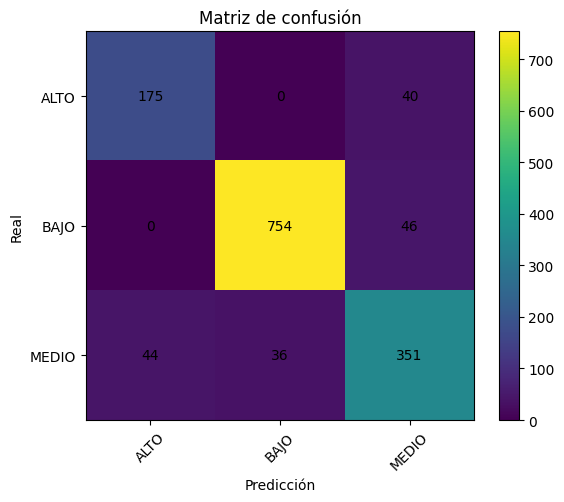

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=labels)
print("Matriz de confusión (filas=real, columnas=pred):")
display(pd.DataFrame(cm, index=[f"Real_{c}" for c in labels], columns=[f"Pred_{c}" for c in labels]))

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(range(len(labels)), labels, rotation=45)
plt.yticks(range(len(labels)), labels)
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()


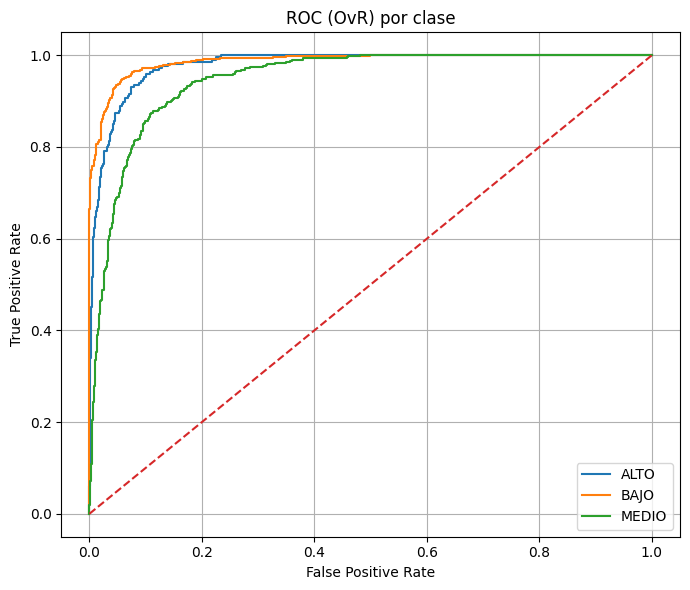

In [20]:
# Binarizar y_test para ROC por clase (One-vs-Rest)
y_test_arr = y_test.to_numpy()

plt.figure(figsize=(7, 6))
ok_any = False

for i, cls in enumerate(labels):
    y_true_bin = (y_test_arr == cls).astype(int)
    y_score = y_proba[:, i]

    # si no hay positivos o no hay negativos en test, ROC no aplica
    if y_true_bin.sum() == 0 or y_true_bin.sum() == len(y_true_bin):
        print(f"⚠️ No se puede ROC para clase {cls} (falta variedad en y_test).")
        continue

    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    plt.plot(fpr, tpr, label=f"{cls}")
    ok_any = True

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (OvR) por clase")
if ok_any:
    plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


,feature,importance
9,prob_riesgo_15,0.224718
8,liquidez_corriente_15,0.208295
13,riesgo_15_BAJO,0.101350
12,riesgo_15_ALTO,0.065455
6,pasivos_corrientes_15,0.056238
7,margen_ganancia_15,0.053669
2,gastos_variables_15,0.050578
14,riesgo_15_MEDIO,0.044381
1,gastos_fijos_15,0.031947
5,activos_corrientes_15,0.030773


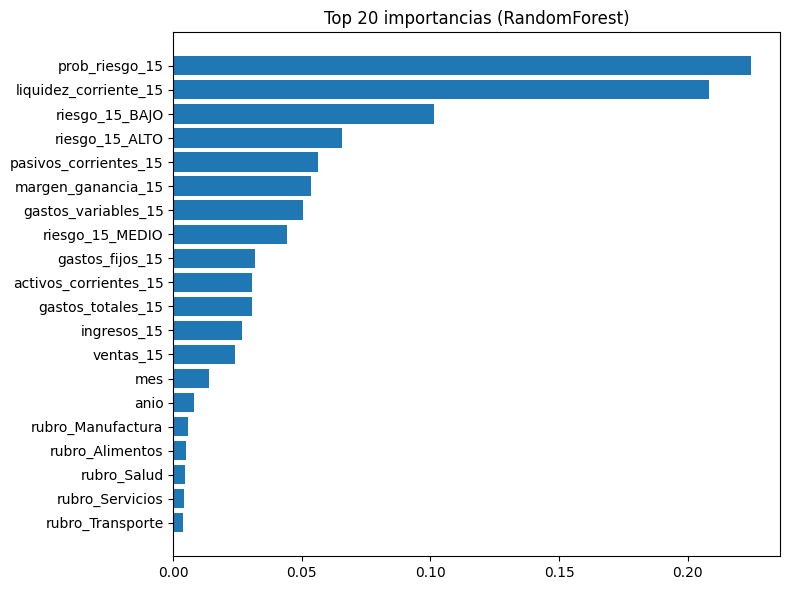

In [21]:
# Extraer nombres de features después del preprocesamiento
pre = model.named_steps["preprocess"]
rf = model.named_steps["clf"]

feature_names = []

# num
if len(numeric_cols) > 0:
    feature_names.extend(numeric_cols)

# cat onehot
if len(categorical_cols) > 0:
    ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
    feature_names.extend(cat_names)

importances = rf.feature_importances_
imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False)

display(imp_df.head(25))

plt.figure(figsize=(8, 6))
top = imp_df.head(20).iloc[::-1]
plt.barh(top["feature"], top["importance"])
plt.title("Top 20 importancias (RandomForest)")
plt.tight_layout()
plt.show()


In [23]:
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join(ARTIFACTS_DIR, f"modelo_riesgo_fin_mes_rf_{timestamp}.joblib")

joblib.dump(model, model_path)

# Guardar metadata útil para el informe
metadata = {
    "target": TARGET,
    "features_used": X_cols,
    "numeric_cols": numeric_cols,
    "categorical_cols": categorical_cols,
    "classes": labels.tolist(),
    "metrics_test": {
        "accuracy": acc,
        "balanced_accuracy": bacc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "mcc": mcc,
        "kappa": kappa,
        "log_loss": ll,
        "roc_auc_ovr": auc_ovr
    }
}

meta_path = os.path.join(ARTIFACTS_DIR, f"metadata_{timestamp}.json")
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("Modelo guardado en:", model_path)
print("Metadata guardada en:", meta_path)


Modelo guardado en: artifacts\modelo_riesgo_fin_mes_rf_20251217_162901.joblib
Metadata guardada en: artifacts\metadata_20251217_162901.json


In [24]:
# Ejemplo: cargar el modelo recién guardado
loaded_model = joblib.load(model_path)

# Tomamos una fila del test como ejemplo (simula "primeros 15 días")
example = X_test.iloc[[0]].copy()

pred = loaded_model.predict(example)[0]
proba = loaded_model.predict_proba(example)[0]

print("Ejemplo (features):")
display(example)

print("Predicción riesgo_fin_mes:", pred)
print("Probabilidades por clase:")
for cls, p in zip(loaded_model.named_steps["clf"].classes_, proba):
    print(f"  {cls}: {p:.4f}")


Ejemplo (features):


,ingresos_15,gastos_fijos_15,gastos_variables_15,gastos_totales_15,ventas_15,activos_corrientes_15,pasivos_corrientes_15,margen_ganancia_15,liquidez_corriente_15,riesgo_15,prob_riesgo_15,rubro,anio,mes
5783,4531.01,2504.9,1090.43,3595.34,120,18321.59,8322.28,0.206503,2.201512,BAJO,0.2753,Comercio,2024,12


Predicción riesgo_fin_mes: BAJO
Probabilidades por clase:
  ALTO: 0.0000
  BAJO: 0.9910
  MEDIO: 0.0090
